# Invasive Weed algorithm
<br>
### Based on fitness function to evaluate seed coordinates (x and y)
```
fitness = x * sin(4*x) ) + ( 1.1 * y * sin( 2 * y)
        where 0 < x < 10 and 0 < y < 10
```
### Find the best seed coordinates (minimum fitness)

In [106]:
# Import necessary libraries
import numpy as np
import random
import math
import collections
import operator
import time
import progressbar
import matplotlib.pyplot as plt

In [107]:
class InvasiveWeed(): # Define class with model name
    def __init__(self, pmax, maxiter, delta_cap, num_exceeded_delta): # Initiate class with required parameters
        seed_array = [] # Initiate empty list to contain tuples of x and y seed coordinates
        for i in range(round(0.1*pmax)): # Initiate 10% of population max seeds with random x and y values between 0 and 10
            x = random.uniform(0, 10) # x = random float between 0 and 10
            y = random.uniform(0, 10) # y = random fload between 0 and 10
            # Append the seed to the seed_array
            seed_array.append((x,y)) 

        self.pmax = pmax
        self.maxiter = maxiter
        self.delta_cap = delta_cap
        self.num_exceeded_delta = num_exceeded_delta
        
        # Initiate delta higher than delta_cap to avoid early iteration stoppage
        delta = delta_cap + 0.01
        
        c = 0 # Initiate int c for num_xceed_delta count
        
        # current_fitness_dict will contain the seed coordinates and their fitness scores
        # for all seeds in our current population (capped to pmax)
        current_fitness_dict = {}
        self.current_fitness_dict = current_fitness_dict
        
        # Initiate list that will contain best fitness score from each iteration
        best_fitness_list =  []
        self.best_fitness_list = best_fitness_list
        
        # Initiate list that will contain best scoring seeds from each iteration
        best_seed_dict = {}
        best_seed_list = []
        self.best_seed_list = best_seed_list
        self.best_seed_dict = best_seed_dict

        # Get the time in seconds to count the runtime of the loop        
        start_time = time.time() 

        
        for i in range(1, maxiter+1): # Iterate n = maxiter times
            fitness_array = self.get_fitness(seed_array) # Get fitness array for current seeds
            fitness_dict = dict(zip(seed_array, fitness_array)) # Make a dictionary containing seed tuple as key and their fitness as values
            
            # Sort seed --> fitness dictionary
            # The lowest scoring fitness value first (the best score)
            sorted_fitness_dict = {k: v for k, v in sorted(fitness_dict.items(), key=lambda item: item[1])} 
            best_seed_dict[list(sorted_fitness_dict.keys())[0]] = list(sorted_fitness_dict.values())[0]
            self.best_seed_dict = best_seed_dict
            
            # Append best seed to global list
            best_seed_list.append(list(sorted_fitness_dict.values())[0])
            
            # Normalize fitness value in the dictionary
            # Increase the distribution of fitness scores so they start with 0 instead of negative values
            normalized_fitness_dict = self.normalize_fitness(sorted_fitness_dict)
            
            # Compute number of children to be made from each seed
            # and output as a new directory with seed as key and number of children as values
            seed_children_dict = self.eval_fitness(normalized_fitness_dict)
            
            # Append best fitness score to the global fitness_array
            best_fitness_list.append(sorted(fitness_array)[0])
            #print(best_fitness_list,"\n")
            
            # Add seeds and their fitness scores from this iteration to the population (current_fitness_dict)
            for seed, fitness in fitness_dict.items():
                current_fitness_dict[seed] = fitness

            
            # If population is bigger than the set pmax
            # we need to trim it by keeping only best scoring seeds
            if len(current_fitness_dict) > pmax:
                    self.prune_seeds()

            
            # Generate new seeds and add them to current array of seeds
            seed_array = seed_array + self.generate_population(seed_children_dict)

            # After 5 iterations (minimum),
            # Start checking whether the delta (difference between last and second last fitness scores)
            # is higher than the cap on the score difference set by the user as delta_cap
            if len(best_seed_dict) > 5:
                # Subtract best fitness from the last two iterations 
                delta = best_fitness_list[-1] - best_fitness_list[-2]
            else:
                # Before 5 iterations the fitness has been very variable and could produce an error with a 0 delta
                # we avoid it by adding 0.01 to the delta to avoid this
                delta = delta_cap + 0.01
            
            # If delta is lower than the delta_cap set bby user
            # add to the counter for threshold of num_exceeded_data
            if delta < delta_cap:
                c += 1
            
            # Otherwise set the counter back to 0
            else:
                c = 0

            # Break the function if the delta has been lower than the delta_cap
            # more than the num_exceeded_data set by the user
            if c >= num_exceeded_delta:
                break
            
                
            self.i = i # Keep track of the last iteration

            

        end_time = time.time() # Get time in seconds
        runtime = end_time - start_time # Get runtime of the model
        self.runtime = runtime # Make runtime accessable inside the class
    
    
    # Function to generate the new seeds in each generation
    # Based on their previous fitness
    def generate_population(self,seed_children_dict):
        new_seeds = [] # Initiate list of new seeds
        
        # Based on how many new children each previous fitness parent produces
        # Inititate new seeds within 0.1 standard distributions from previous parent coordinates
        for seed, nchildren in seed_children_dict.items():
            for _ in range(nchildren): # this loop will run as long as nchildren for each parent
                x = seed[0] # X coordinate
                y = seed[1] # Y coordinate
                new_x = random.gauss(x,0.1) # Initiate new x
                new_y = random.gauss(y,0.1) # Initiate new y

                # If x was outside set bounds (0,10), Initiate new x until a correct one is produced
                while new_x < 0 or new_x > 10:
                    new_x=random.gauss(x,0.1)

                # If y was outside set bounds (0,10), Initiate new y until a correct one is produced
                while new_y < 0 or new_y > 10:
                    new_y=random.gauss(y,0.1)

                # Append new seeds to the population
                new_seeds.append((new_x, new_y))

        # Return new seeds from the function
        return new_seeds
    
    # Get fitness of new seeds
    def get_fitness(self,seed_array):
        fitness_array = [] # Initiate fitness array for new seeds
        for seed in seed_array:
            x = seed[0] #  X coordinate
            y = seed[1] #  Y coordinate
            
            # Functon to convert x and y coordinates into a fitness value
            fitness = ( x * math.sin(4*x) ) + ( 1.1 * y * math.sin( 2 * y) )
            
            # Append fitness to the fitness array
            fitness_array.append(fitness)
            
        return fitness_array
    
    
    # Function to normalize fitness into values from 0 to max
    # Slide the values to positives based on the lowest negative values
    def normalize_fitness(self,sorted_fitness_dict):
        # Get the seed with the best/lowest fitness
        lowest_fitness_element = list(sorted_fitness_dict.items())[0]
        
        new_vals = [] # Initiate list for new fitness values
        for val in sorted_fitness_dict.values():
             # Subtract value from the lowest value in sorted fitness dictionary
            new_val = val - list(sorted_fitness_dict.values())[0]
            new_vals.append(new_val)
        
        # Save sorted dictionary with new values of fitness
        sorted_fitness_dict = dict(zip(sorted_fitness_dict.keys(), new_vals))
        
        # Keep the lowest fitness element to be accessed
        self.lowest_fitness_element = lowest_fitness_element
        return sorted_fitness_dict

    # Generate variable number of seeds based on the fitness score of the parent seed
    def eval_fitness(self,normalized_fitness_dict):
        children_seed_list = [] # Initiate list for new seeds number
        maximum = max(normalized_fitness_dict.values()) # get maximum fitness value
        
        # Perform fitness to N children transformation based on each fitness value
        # and the maximum fitness value from this generation
        for val in normalized_fitness_dict.values(): 
            # (val+0.00001) makes sure that the 0 error does not occur
            # Other calculations were attempted but this one proved the most efficient for the task
            num_seed = round( ( (val+0.000001) ) / maximum)
            
            # Append the num of new children to the pre-initialized list
            children_seed_list.append(num_seed)

        # Create dictionary containing seeds and reversed number of children
        # That is because the lowest fitness score is one that should actually have most children
        seed_children_dict = dict(zip(normalized_fitness_dict.keys(), children_seed_list[::-1]))

        return seed_children_dict

    # Function to prune the seeds to the number of population maximum (pmax)
    def prune_seeds(self):
        # Sort the current dictionary with seeds and their fitness based on fitness
        sorted_current_fitness_dict = {k: v for k, v in sorted(self.current_fitness_dict.items(), key=lambda item: item[1])}
        
        # Prune the sorted dictionary to population max (pmax) and return as class fitness dictionary
        self.current_fitness_dict = dict(list(sorted_current_fitness_dict.items())[0:self.pmax]) 
    
    # Return best iteration from class
    def return_best_iteration_(self):
        return self.i
    
    # Return model runtime from class
    def return_runtime_(self):
        return self.runtime
    
    # Return best seed from class
    def return_best_seed_(self):
        # Make sure the current best fitness is the minimum of fitness values from the iterations
        best_seed_dict = {k: v for k, v in sorted(self.best_seed_dict.items(), key=lambda item: item[1])}
        
        # Return best seed
        return list(min(best_seed_dict.items(), key=lambda x: x[1]))
    
    # Return best fitness value from class
    def return_best_fitness_(self):
        return list(self.best_seed_list)
    
    # Plot best fitness from each iteration/generation
    def plot_fitnesses_(self):
        plt.plot(self.best_seed_list)
        plt.title("Best fitness scores from each iteration/generation")
        return plt.show()
    
    def __str__(self):
        return  f"InvasiveWeed(pmax = {self.pmax}, maxiter = {self.maxiter}, delta_cap = {self.delta_cap}, num_exceeded_delta = {self.num_exceeded_delta})\n"
    

In [108]:
# Perform grid search to find the best parameters based on the params dictionary
def grid_search(params):
    grid_search_dict = {} # Start dictionary for grid search results
    runtimes = [] # Start list for runtimes for each time model runs
    param_no = np.prod([len(x) for x in params.values()]) # Compute number of totals iterations to run for the progress bar
    total = progressbar.ProgressBar(maxval=param_no) # Initiate progress bar
    c = 0 # Initiate int c to update the progress bar
    total.start() # Start progress bar
    best_seeds = [] # Initiate list for best seeds from the entire grid search
    for pmax in params['pmax']: # For each population max value
        for maxiter in params['maxiter']: # For each max iteration value
            for delta_cap in params['delta_cap']: # For each delta_cap value
                for num_exceeded_delta in params['num_exceeded_delta']: # For each num exeeded delta value
                    model = InvasiveWeed(pmax, maxiter, delta_cap, num_exceeded_delta) # Iniiate model with current parameters
                    best_fitness_score = model.return_best_fitness_() # Get best fitness score from the model
                    best_iteration = model.return_best_iteration_() # Get best iteration from the model ( Should be last/highest one )\
                    # Update grid search dictionary with results
                    grid_search_dict[pmax, maxiter, delta_cap, num_exceeded_delta, best_iteration] = best_fitness_score 
                    runtimes.append(model.return_runtime_()) # Append runtime of current model to results dictionary
                    best_seeds.append(model.return_best_seed_()) # Append best seeds from best iteration from the model to the results dictionary
                    total.update(c) # Update progressbar with the int c value
                    c+=1 # update int c value
                    
                    
    total.finish() # Finish progressbar
    res_dic = {k: min(v) for k, v in grid_search_dict.items()} # res dict contains seed and minimum (best) fitness from each model run
    sorted_results_dict = {k: v for k, v in sorted(res_dic.items(), key=lambda item: item[1])}  # Sort resulst dictionary
    sorted_seeds = sorted(best_seeds, key=lambda x: x[1]) # sort best seeds dictionary by fitness
    
    best_params = list(sorted_results_dict.keys())[0] # Get params for best seed from gridsearch
    best_fitness = list(sorted_results_dict.values())[0] # Get best fitness from gridsearch
    
    best_seed = sorted_seeds[0][0] # Get best seed from gridsearch
    
    best_round_fitnesses = list(grid_search_dict[best_params]) # Get all fitnesses from the best model from gridsearch
    
    # Print the best model as well as the current best parameters
    # and best iteration, total runtime, best fitness and best seed from gridsearch
    print(f"\nGridsearch results:")
    print(f"\tBest model:")
    print(f"\t\tInvasiveWeed(pmax = {best_params[0]}, maxiter = {best_params[1]}, delta_cap = {best_params[2]}, num_exceeded_delta = {best_params[3]})\n")
    print(f"\tStopped at iteration: {best_params[4]}\n")
    print(f"\tTotal runtime: {round(sum(runtimes),3)} seconds\n")
    print(f"\tBest fitness: {best_fitness}")
    print(f"\tBest seed coordinates: {best_seed}")
    
    # Return best params, best fitness and all fitnesses from best round from the function
    return best_params, best_fitness, best_round_fitnesses
                


Gridsearch results:
	Best model:
		InvasiveWeed(pmax = 1000, maxiter = 20, delta_cap = 1e-08, num_exceeded_delta = 6)

	Stopped at iteration: 14

	Total runtime: 8.263 seconds

	Best fitness: -18.55460148132076
	Best seed coordinates: (9.039792749832477, 8.670142196553327)


100% |########################################################################|


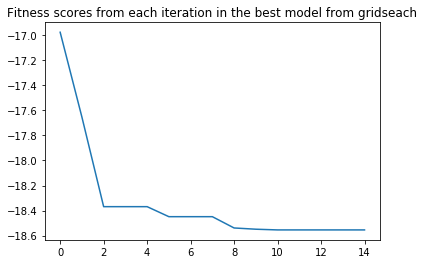

In [109]:
## Grid search for the best seed (minimum fitness) with different parameters

# Dictionary with parameters to be run for gridsearch
params = {
    'pmax' : [10**2, 10**3, 2000], # Population max variable
    'maxiter' : [15, 20], # Max iteration variable
    'delta_cap' : [10**-6, 10**-8], # Define the change to be accounted for in num_exceeded_delta
    
    # This variable defines how many times the difference between the fitness score of the last iteration versus
    # The second last iteration can exeed the value of delta_cap (the max delta value)
    'num_exceeded_delta' : [6, 8, 10]
}

# Run gridsearch for parameters
best_params, best_fitness, best_round_fitnesses = grid_search(params)

# plot best fitness score for each iteration in the best model from gridseach
plt.plot(best_round_fitnesses)
plt.title("Fitness scores from each iteration in the best model from gridseach")
plt.show()

Model:  InvasiveWeed(pmax = 1000, maxiter = 20, delta_cap = 1e-08, num_exceeded_delta = 6)

Best iteration (stopped at): 11
Model runtime: 2.431821584701538

Best fitness: -18.55264213502686
Best seed: (9.03861597335993, 8.678574576884593)



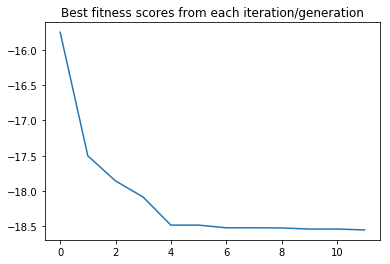

In [118]:
# Check reliability of the model:
# Run model one single time with the best parameters from gridsearch
# The resulting best seed and fitness value should be similair to the gridsearch result
# Print model parameters, results and plot the fitness from each iteration

model = InvasiveWeed(best_params[0], best_params[1], best_params[2], best_params[3])
print("Model: ", model)
print(f"Best iteration (stopped at): {model.return_best_iteration_()}")
print(f"Model runtime: {model.return_runtime_()}\n")
print(f"Best fitness: {min(model.return_best_fitness_())}")
print(f"Best seed: {model.return_best_seed_()[0]}\n")

model.plot_fitnesses_()